# decentralized
Primary development and execution script for evaluation of game theoretic control algorithms.

References:
1. [Fridovich-Keil - ilqgames](https://github.com/HJReachability/ilqgames/blob/master/python/dynamical_system.py)
1. [anass - ilqr](https://github.com/anassinator/ilqr)
1. [Jackson - AL iLQR Tutorial](https://bjack205.github.io/papers/AL_iLQR_Tutorial.pdf)

In [1]:
from itertools import combinations

from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from decentralized import (
    iLQR, RecedingHorizonController,
    MultiDynamicalModel, CarDynamics, UnicycleDynamics, BicycleDynamics,
    ObstacleCost, ReferenceCost, CouplingCost, AgentCost, MultiAgentCost,
    NumericalDiffCost, Point
)

In [2]:
%matplotlib ipympl
plt.rcParams['axes.grid'] = True
np.set_printoptions(precision=6)

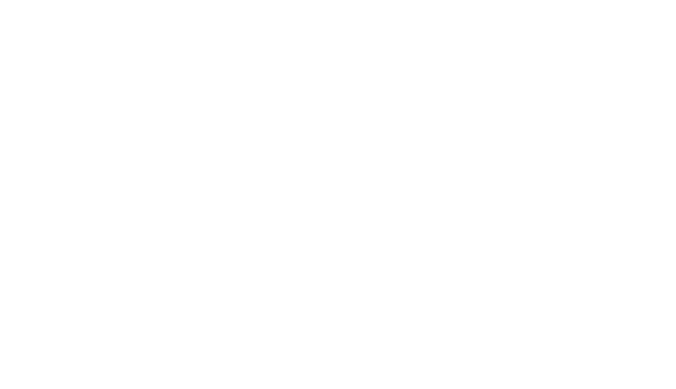

In [3]:
f1 = plt.figure(figsize=(6.76, 3.89))

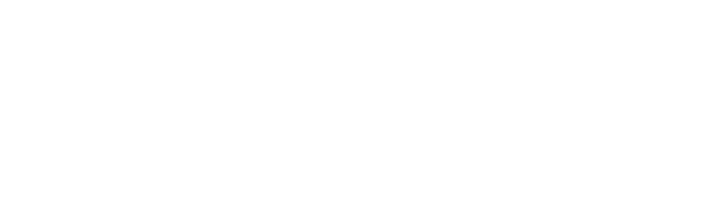

In [4]:
f2 = plt.figure(figsize=(7.15, 2.21))

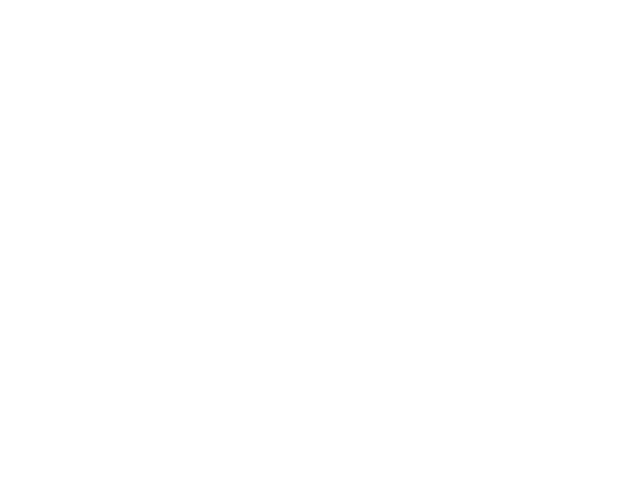

In [5]:
f3 = plt.figure()

## Multi-Agent

In [6]:
dt = 0.05
N = 80
n_lqr_iter = 50
tol = 1e-3

x0 = np.array([
    -4, 1, 0, 0,
    -1, -4, 0, np.pi/2,
     # 1, -4, 0, np.pi/2
])

OBS_WEIGHT = 1e3
REF_WEIGHT = 1.0
COUPLING_WEIGHT = 100.0
COUPLING_RADIUS = 1.0

obstacles = []
# obstacles = [ObstacleCost((0, 1), Point(-0.5, -0.1), 0.5, OBS_WEIGHT)]

uni1 = UnicycleDynamics(dt)
uni1_ref = ReferenceCost(xf=np.array([4, -1, 0, 0]),
                        Q=np.diag([1, 1, 0, 0]),
                        R=np.eye(2) * 4,
                        # Qf=1e3*Q,
                        Qf=1e3*np.eye(4),
                        weight=REF_WEIGHT)
uni1_cost = AgentCost([uni1_ref] + obstacles)

uni2 = UnicycleDynamics(dt)
uni2_ref = ReferenceCost(xf=np.array([2, 4, 0, np.pi/2]),
                        Q=np.diag([1, 1, 0, 0]),
                        R=np.eye(2) * 4,
                        # Qf=1e3*Q,
                        Qf=1e3*np.eye(4),
                        weight=REF_WEIGHT)
uni2_cost = AgentCost([uni2_ref] + obstacles)

uni3 = UnicycleDynamics(dt)
uni3_ref = ReferenceCost(xf=np.array([0, 4, 0, np.pi/2]),
                        Q=np.diag([1, 1, 0, 0]),
                        R=np.eye(2) * 4,
                        # Qf=1e3*Q,
                        Qf=1e3*np.eye(4),
                        weight=REF_WEIGHT)
uni3_cost = AgentCost([uni3_ref] + obstacles)

# dynamics = MultiDynamicalModel([uni1, uni2, uni3])
dynamics = MultiDynamicalModel([uni1, uni2])

# pos_inds = [(0, 1), (4, 5), (8, 9)]
pos_inds = [(0, 1), (4, 5)]
coupling_costs = CouplingCost(pos_inds, radius=COUPLING_RADIUS, weight=COUPLING_WEIGHT)

multicost = MultiAgentCost([uni1_cost, uni2_cost, uni3_cost], [coupling_costs], dynamics.x_dims, dynamics.u_dims)

### Vanilla iLQR
Optimize the initial state over the controller's horizon.

In [7]:
N = 100
ilqr = iLQR(dynamics, multicost, N=N)
U0 = 1e-2 * np.random.randn(N, dynamics.n_u)
# U0 = np.zeros((N, dynamics.n_u))
X, U, Jf = ilqr.solve(x0, U=U0, n_lqr_iter=n_lqr_iter, tol=tol)

0/50	J: 154526
1/50	J: 7489.67	μ: 0.5	Δ: 0.5
2/50	J: 7469.73	μ: 0.125	Δ: 0.25
3/50	J: 7362.32	μ: 0.015625	Δ: 0.125
4/50	J: 6115.03	μ: 0.000976562	Δ: 0.0625


In [21]:
plt.figure(f1, clear=True)
ilqr.plot(X,
          do_headings=False, 
          surface_plot=True, 
          log_colors=False,
          coupling_radius=COUPLING_RADIUS,
          axis=(-6, 6, -6, 6),
          title_suffix=f': $J_f$ = {Jf:.3g}',
          agent_ind=0
         )

In [13]:
axis = (-6, 6, -6, 6)
STEP = 0.1

In [20]:
pts = np.mgrid[axis[0]:axis[1]:STEP, axis[2]:axis[3]:STEP].T.reshape(-1,2)

(14400, 2)

### RHC iLQR
Optimize the initial state over a receding horizon according to a step size with additive noise.

In [8]:
step_size = 10
ilqr = iLQR(dynamics, multicost, N=N)
rhc = RecedingHorizonController(x0, ilqr, step_size)

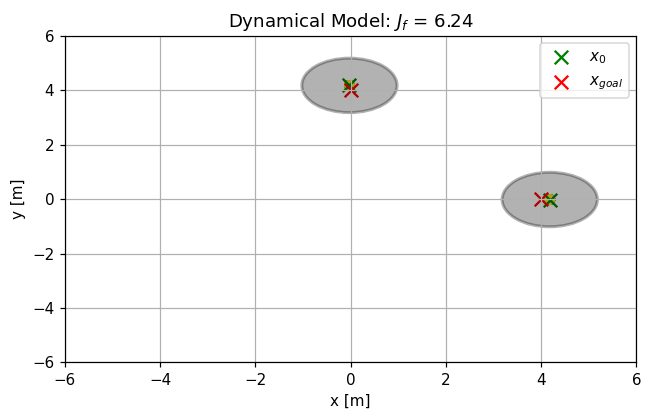

Converged!


In [20]:
X = np.zeros((0, dynamics.n_x))
# U0 = np.zeros((N, ilqr.n_u))
U0 = 1e-2 * np.random.randn(N, ilqr.n_u)
for Xi, Ui, J in rhc.solve(U0, J_converge=10.0, n_lqr_iter=n_lqr_iter, tol=tol):
    print(f"{Xi.shape=}\t{Ui.shape=}\t{J=}")
    display.clear_output(wait=True)
    ilqr.plot(Xi,
          title_suffix=f': $J_f$ = {J:.3g}',
          do_headings=False, 
          surface_plot=False,
          log_colors=True,
          axis=(-6, 6, -6, 6),
          agent_ind=0
    )
    display.display(plt.gcf())
    plt.pause(0.1)
    
    X = np.vstack([X, Xi])

In [99]:
dist = np.linalg.norm(X[:, pos_inds[0]] - X[:, pos_inds[1]], axis=1)
crash_mask = dist < COUPLING_RADIUS

costs = np.zeros_like(dist)
for i, (x, u) in enumerate(zip(X, U)):
    costs[i] = multicost(x, u)

In [100]:
plt.figure(f2, clear=True)
plt.clf()

f2.add_subplot(2,1,1)
plt.plot(dist)
plt.axhline(COUPLING_RADIUS, c='r')
plt.ylabel('Distance')

f2.add_subplot(2,1,2)
plt.plot(costs)
plt.ylabel('Cost')
plt.show()

### Splitting up the Problem

**GOAL: be able to split up a NavigationProblem (MultiDynamicalModel + MultiAgentCost) into sub-problems**
Tasks:
- initialize all sub-problems with either a) centralized solution or b) selfish solution
- when do we split the problem?
    + in the **curent** rolled out full trajectory, when two agents come within each others' planning radii
- how do we split the problem?
    + assign id's to each DynamicalModel and AgentCost (or combine them somehow) and split up accordingly

In [101]:
U0 = 1e-2 * np.random.randn(N, ilqr.n_u)
solve_kwargs = {
    'n_lqr_iter': 50,
    'tol': 1e-3
}

X_init = np.zeros((N+1, 0))
U_init = np.zeros((N, 0))
J_init = 0.0

In [102]:
# Solve the individual problems to initialize the decentralized problem.
for dynamics_i, cost_i, x0_i, u0_i in zip(
        dynamics.submodels, 
        multicost.agent_costs, 
        *dynamics.partition(x0, U0)):
    ilqr_i = iLQR(dynamics_i, cost_i, N)
    X_i, U_i, Ji = ilqr_i.solve(x0_i, u0_i, **solve_kwargs)
    X_init = np.hstack([X_init, X_i])
    U_init = np.hstack([U_init, U_i])
    J_init += Ji

0/50	J: 74851.4
1/50	J: 8521.99	μ: 0.5	Δ: 0.5
2/50	J: 2864.83	μ: 0.125	Δ: 0.25
3/50	J: 2850.66	μ: 0.015625	Δ: 0.125
4/50	J: 2843.95	μ: 0.000976562	Δ: 0.0625
5/50	J: 2840.52	μ: 3.05176e-05	Δ: 0.03125
0/50	J: 80085.8
1/50	J: 4234.73	μ: 0.5	Δ: 0.5
2/50	J: 3062.19	μ: 0.125	Δ: 0.25
0/50	J: 71701.4
1/50	J: 5955.29	μ: 0.5	Δ: 0.5
2/50	J: 2708.19	μ: 0.125	Δ: 0.25
3/50	J: 2700.77	μ: 0.015625	Δ: 0.125


In [105]:
ilqr.plot(X_init,
          title_suffix=f': $J_f$ = {J_init:.3g}',
          do_headings=False, 
          surface_plot=True,
          log_colors=False,
          axis=(-6, 6, -6, 6),
          agent_ind=0
)

In [ ]:
def decentralize_game(controller, x0, U0, planning_radius=5.0, coupling_radius=1.0):
    """Split up the centralized problem into multiple decentralized 
       sub-problems where possible
       
    """
    
    X0 = controller._rollout(x0, U0)
    
    dist = np.linalg.norm(X_init[:, pos_inds[0]] - X_init[:, pos_inds[1]], axis=1)
    plan_mask = dist < planning_radius

In [38]:
planning_radius = 5.0

dist = np.linalg.norm(X_init[:, pos_inds[0]] - X_init[:, pos_inds[1]], axis=1)
crash_mask = dist < COUPLING_RADIUS

In [ ]:
dist < planning_radius

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [41]:
dist < planning_radius

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [36]:
multicost.coupling_costs[0].pos_inds

[(0, 1), (4, 5)]

## Single Agent

In [6]:
from decentralized.analytical_models import CarDynamics as CarDynamicsAn

In [10]:
dt = 0.1
N = 50
n_lqr_iter = 50
tol = 1e-6

REF_WEIGHT = 1.0
OBS_WEIGHT = 1e3

# dynamics = DoubleInt1dDynamics(dt)
# x0 = np.array([2, 0])
# xf = np.array([0, 1])
# Q = np.eye(2)
# R = np.eye(1)

# dynamics = DoubleInt2dDynamics(dt)
# x0 = np.array([10, 10, 0, 0])
# xf = np.array([0, 0, 0, 0])
# Q = np.diag([1, 1, 0, 0])
# R = np.eye(2)

# dynamics = CarDynamicsAn(dt)
# dynamics = CarDynamics(dt)
# x0 = np.array([5, 0, np.pi/2])
# xf = np.array([-5, 0, np.pi/2])
# Q = np.diag([1, 1, 0])
# R = np.eye(2) * 10

dynamics = UnicycleDynamics(dt)
x0 = np.array([-10, 10, 0, 0])
xf = np.array([0, 0, 0, 0])
Q = np.diag([1, 1, 0, 0])
R = np.eye(2)

# dynamics = BicycleDynamics(dt)
# x0 = np.array([10, 10, np.pi/2, 0, 0])
# xf = np.array([0, 0, 0, 0, 0])
# Q = np.diag([1, 1, 0, 0, 0])
# R = np.eye(2)

Qf = np.eye(Q.shape[0]) * 1e3
reference = ReferenceCost(xf, Q, R, Qf, REF_WEIGHT)
# obstacles = [ObstacleCost((0, 1), Point(3, 3), 2, OBS_WEIGHT),
#              ObstacleCost((0, 1), Point(9, 7), 2, OBS_WEIGHT),
#              ObstacleCost((0, 1), Point(3, 10), 3, OBS_WEIGHT)]
# obstacles = [ObstacleDiffCost((0, 1), Point(0, 0.1), 2, OBS_WEIGHT)]
# obstacles = [ObstacleCost((0, 1), Point(0, 0.1), 2, OBS_WEIGHT)]
obstacles = []

agent_cost = AgentCost(obstacles + [reference])
multicost = MultiAgentCost([agent_cost], [], [dynamics.n_x], [dynamics.n_u])

### Vanilla iLQR
Optimize the initial state over the controller's horizon.

In [11]:
ilqr = iLQR(dynamics, multicost, N=N)
U0 = np.zeros((N, dynamics.n_u))
X, U, J = ilqr.solve(x0, U=U0, n_lqr_iter=n_lqr_iter, tol=tol)

0/50	J: 210000
1/50	J: 106521	μ: 0.5	Δ: 0.5
2/50	J: 17922	μ: 0.125	Δ: 0.25
3/50	J: 7643.03	μ: 0.015625	Δ: 0.125
4/50	J: 5614.29	μ: 0.000976562	Δ: 0.0625
5/50	J: 4326.51	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 4187.73	μ: 0	Δ: 0.015625
7/50	J: 3567.48	μ: 0	Δ: 0.0078125
8/50	J: 3551.82	μ: 0	Δ: 0.00390625
9/50	J: 3258.29	μ: 0	Δ: 0.00195312
10/50	J: 3159.41	μ: 0	Δ: 0.000976562
11/50	J: 3107.26	μ: 0	Δ: 0.000488281
12/50	J: 3083.88	μ: 0	Δ: 0.000244141
13/50	J: 3072.67	μ: 0	Δ: 0.00012207
14/50	J: 3067.64	μ: 0	Δ: 6.10352e-05
15/50	J: 3065.19	μ: 0	Δ: 3.05176e-05
16/50	J: 3064.02	μ: 0	Δ: 1.52588e-05
17/50	J: 3063.42	μ: 0	Δ: 7.62939e-06
18/50	J: 3063.11	μ: 0	Δ: 3.8147e-06
19/50	J: 3062.94	μ: 0	Δ: 1.90735e-06
20/50	J: 3062.84	μ: 0	Δ: 9.53674e-07
21/50	J: 3062.79	μ: 0	Δ: 4.76837e-07
22/50	J: 3062.75	μ: 0	Δ: 2.38419e-07
23/50	J: 3062.73	μ: 0	Δ: 1.19209e-07
24/50	J: 3062.72	μ: 0	Δ: 5.96046e-08
25/50	J: 3062.72	μ: 0	Δ: 2.98023e-08
26/50	J: 3062.71	μ: 0	Δ: 1.49012e-08


In [12]:
X

array([[-1.000000e+01,  1.000000e+01,  0.000000e+00,  0.000000e+00],
       [-1.000000e+01,  1.000000e+01,  1.308949e+00, -2.363703e-01],
       [-9.883461e+00,  9.940400e+00,  2.440631e+00, -4.727404e-01],
       [-9.686399e+00,  9.796409e+00,  3.401722e+00, -6.310273e-01],
       [-9.430379e+00,  9.572421e+00,  4.204097e+00, -7.187648e-01],
       [-9.126390e+00,  9.282016e+00,  4.860776e+00, -7.625484e-01],
       [-8.781863e+00,  8.939127e+00,  5.384694e+00, -7.830141e-01],
       [-8.403663e+00,  8.555833e+00,  5.788363e+00, -7.920885e-01],
       [-7.998675e+00,  8.142269e+00,  6.083766e+00, -7.958745e-01],
       [-7.573662e+00,  7.706968e+00,  6.282310e+00, -7.973567e-01],
       [-7.135071e+00,  7.257177e+00,  6.394794e+00, -7.980043e-01],
       [-6.688886e+00,  6.799080e+00,  6.431394e+00, -7.985705e-01],
       [-6.240562e+00,  6.337957e+00,  6.401651e+00, -7.994707e-01],
       [-5.794999e+00,  5.878301e+00,  6.314460e+00, -8.009650e-01],
       [-5.356538e+00,  5.423904e+

In [14]:
plt.figure(f1, clear=True)
ilqr.plot(
    X,
    do_headings=False, 
    surface_plot=False, 
    log_colors=True,
    coupling_radius=None,
    title_suffix=f': $J_f$ = {J:.3g}')

### RHC iLQR
Optimize the initial state over a receding horizon according to a step size with additive noise.

In [15]:
step_size = 50
ilqr = iLQR(dynamics, multicost, N=N)
rhc = RecedingHorizonController(x0, ilqr, step_size)

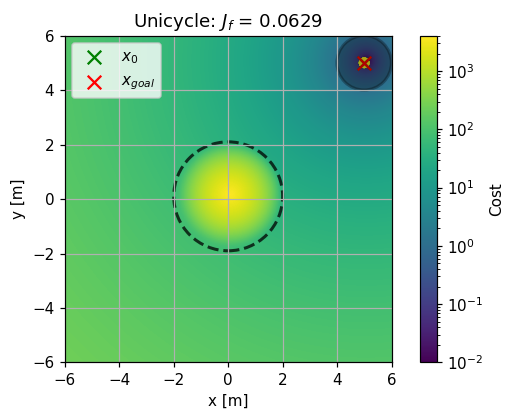

Converged!


In [ ]:
U = np.zeros((N, ilqr.n_u))
x = x0
for X, U, J in rhc.solve(U, n_lqr_iter=n_lqr_iter, tol=tol):
    # Apply the noisy control sequence.
    # X, J = rhc._controller._rollout(rhc.x, U)
    # rhc.x = X[-1]
    
    display.clear_output(wait=True)
    ilqr.plot(X,
          title_suffix=f': $J_f$ = {J:.3g}',
          do_headings=False, 
          surface_plot=True,
          log_colors=True,
          axis=(-6, 6, -6, 6))
    display.display(plt.gcf())
    plt.pause(1)

## Miscellaneous

In [136]:
def animate(f, axis=None):
    """Callback to render the current frame as an image."""
    
    if axis is None:
        axis = (-7, 7, -7, 7)
    
    ilqr.plot(X[:f],
              Jf=Jf,
              do_headings=False, 
              surface_plot=False, 
              log_colors=True,
              coupling_radius=COUPLING_RADIUS,
              axis=axis
             )
    plt.ylim(axis[-2:])

In [137]:
gifname = 'traj.gif'
plt.figure(f3, clear=True)
anim = FuncAnimation(f3, animate, frames=range(1,N+1))
anim.save(gifname, fps=5)

MovieWriter ffmpeg unavailable; using Pillow instead.


IndexError: list index out of range